# Multi-Armed Bandit Demo

In [1]:
import numpy as np
import random

from matplotlib import pyplot as plt

import numba

from tqdm.notebook import tqdm

# needed for our loss plots
from IPython.display import clear_output

# using inline, have to set the figure bigger
%matplotlib inline


# set figure parameters so they look pretty
import matplotlib.pylab as pylab

# Use the Gill Sans font
import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {'legend.fontsize': 14,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20={
    'deep_blue' : (31, 119, 180), 'light_blue' : (174, 199, 232),
    'deep_orange' :  (255, 127, 14), 'light_orange' : (255, 187, 120), 
    'deep_green' :(44, 160, 44), 'light_green' : (152, 223, 138),
    'deep_red' : (214, 39, 40), 'light_red' : (255, 152, 150), 
    'deep_violet' : (148, 103, 189), 'light_violet' : (197, 176, 213), 
    'deep_brown' : (140, 86, 75), 'light_brown': (196, 156, 148), 
    'deep_pink' : (227, 119, 194), 'light_pink' : (247, 182, 210), 
    'deep_gray' : (127, 127, 127), 'light_gray' : (199, 199, 199), 
    'deep_olive' : (188, 189, 34), 'light_olive' : (219, 219, 141), 
    'deep_cyan' : (23, 190, 207), 'light_cyan' : (158, 218, 229)
}

for key in tableau20.keys():    
    r, g, b = tableau20[key]    
    tableau20[key] = (r / 255., g / 255., b / 255.)

*****
## Helper Functions

We'll need a bootstrap function to compute the uncertainty in the payout rate, and a bandit class for us to create multiple bandits

In [2]:
class Bandit:
    
    def __init__(self, payout):
        self.payout = payout
        
    def pull_arm(self):
        rand = random.random()
        if rand < self.payout:
            return 1
        else:
            return 0

In [3]:
@numba.jit
def bootstrap(data_set, n_bootstraps = 100):
    
    avgs = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        
        sub_sample = np.random.choice(data_set, size=len(data_set))
        avgs[i] = np.mean(sub_sample)
        
    return np.mean(avgs), np.std(avgs)

*****
## Setting Up The Bandits

For this project, we'll use the same set of bandits for the sake of comparison.

In [4]:
bandits = []
payouts = [.05, .3, .29, .21]

for idx, payout in enumerate(payouts):
    bandits.append(Bandit(payout))

*****
## Random Sampling

This is a brute force method for finding the highest payout from an individual bandit. Here, we will repeatedly pull a bandit at random and keep track of the individual payouts and uncertainties. We will also keep track of the cumulative payout, which is what we're trying to maximize.

In [5]:
# First set up some histories

cum_payout_hist = []

payouts_hist = {}
payouts_mean = {}
payouts_std = {}

for idx, payout in enumerate(payouts):
    payouts_hist[idx] = []
    payouts_mean[idx] = []
    payouts_std[idx] = []

In [6]:
n_pulls = 10000
n_bandits = 4
cum_payout = 0
for idx in tqdm(range(n_pulls)):
    
    rand_idx = random.randint(0, n_bandits-1)
    
    payout = bandits[rand_idx].pull_arm()
    cum_payout += payout
    cum_payout_hist.append(cum_payout)
    
    payouts_hist[rand_idx].append(payout)
    
    avg, std = bootstrap(np.array(payouts_hist[rand_idx]))
    payouts_mean[rand_idx].append(avg)
    payouts_std[rand_idx].append(std)


/opt/anaconda3/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


In [7]:
for key in payouts_hist.keys():
    payouts_hist[key] = np.array(payouts_hist[key])
    payouts_mean[key] = np.array(payouts_mean[key])
    payouts_std[key]  = np.array(payouts_std[key])

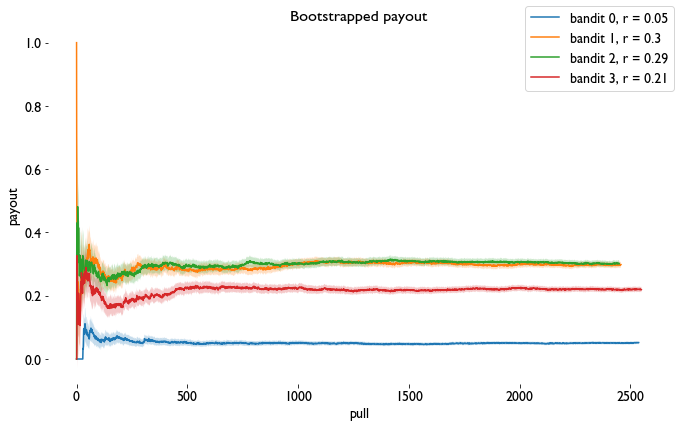

In [8]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.plot(payouts_mean[idx], label='bandit {}, r = {}'.format(idx, payouts[idx]))
    ax.fill_between(range(len(payouts_mean[idx])), payouts_mean[idx]+payouts_std[idx], payouts_mean[idx]-payouts_std[idx], alpha=.25)
ax.set_xlabel('pull')
ax.set_ylabel('payout')
ax.set_title('Bootstrapped payout')
fig.legend()
fig.tight_layout()
pass;

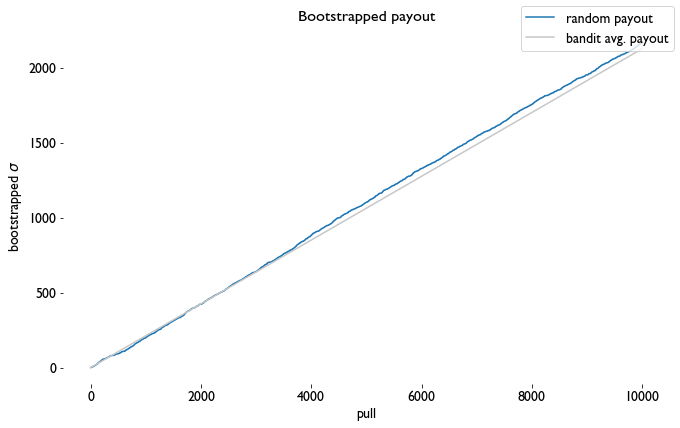

In [9]:
fig, ax = plt.subplots()

pulls = np.linspace(0, len(cum_payout_hist), len(cum_payout_hist))

ax.plot(cum_payout_hist, label='random payout')
ax.plot(np.average(payouts)*pulls, label='bandit avg. payout', c=tableau20['light_gray'])
    
ax.set_xlabel('pull')
ax.set_ylabel(r'bootstrapped $\sigma$')
ax.set_title('Bootstrapped payout')
fig.legend()
fig.tight_layout()
pass;

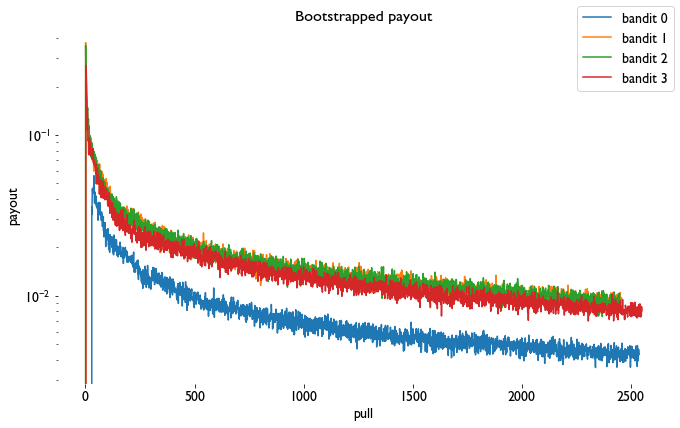

In [10]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.semilogy(payouts_std[idx], label='bandit {}'.format(idx))
    
ax.set_xlabel('pull')
ax.set_ylabel('payout')
ax.set_title('Bootstrapped payout')
fig.legend()
fig.tight_layout()
pass;

*****
## Smarter Bandit

One thing we found is that we can quickly distinguisha few of the bandits as not being optimal, and the random sampling from each evenly accomplishes one goal -- learning the payout rates of each bandit -- but does not solve our goal -- get the highest payout.

To do that, we first implement a naive dropout approach. We run each bandit to get enough measurements to start having some confidence in the results, maybe a few hundred pulls. Then we start bootstrapping the data and if a bandit becomes clearly smaller than all others, we stop pulling that bandit.

In [17]:
# First set up some histories

cum_payout_hist_dropout = []

payouts_hist = {}
payouts_mean = {}
payouts_std = {}



for idx, payout in enumerate(payouts):
    payouts_hist[idx] = []
    payouts_mean[idx] = []
    payouts_std[idx] = []

In [18]:
def check_bandits(mean, std):
    
    drop_bandits = []
    
    for test_key in payouts_mean.keys():
        check_bandit_low = payouts_mean[test_key][-1] + 2.*payouts_std[test_key][-1]
        drop_bandit = False
        for key in payouts_mean.keys():
            if check_bandit_low < payouts_mean[key][-1] - 2.*payouts_std[key][-1]:
                drop_bandit = True
                
        if drop_bandit:
            drop_bandits.append(test_key)
    
    if drop_bandits:
        return drop_bandits
    else:
        return False

In [19]:
n_pulls = 10000
n_bandits = 4
cum_payout = 0
burnoff_time = 100

# for keeping track of which bandits we aren't pulling anymore
dropped_bandits = []

for idx in tqdm(range(n_pulls)):
    
    rand_idx = random.randint(0, n_bandits-1)
    
    # keep pulling until you get a valid index
    while rand_idx in dropped_bandits:
        rand_idx = random.randint(0, n_bandits-1)
        
    payout = bandits[rand_idx].pull_arm()
    cum_payout += payout
    cum_payout_hist_dropout.append(cum_payout)

    payouts_hist[rand_idx].append(payout)

    avg, std = bootstrap(np.array(payouts_hist[rand_idx]))
    payouts_mean[rand_idx].append(avg)
    payouts_std[rand_idx].append(std)

    # start checking for dropped indexes
    if idx > burnoff_time:

        drop = check_bandits(payouts_mean, payouts_std)
        if drop:
            for bandit in drop:
                if bandit not in dropped_bandits:
                    dropped_bandits.append(bandit)
        # if we've dropped all the other bandits, we can quit   

        

In [20]:
for key in payouts_hist.keys():
    payouts_hist[key] = np.array(payouts_hist[key])
    payouts_mean[key] = np.array(payouts_mean[key])
    payouts_std[key]  = np.array(payouts_std[key])

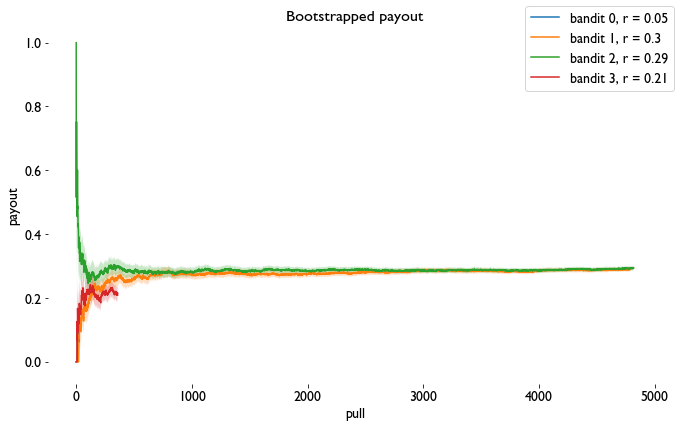

In [21]:
fig, ax = plt.subplots()

for idx in range(n_bandits):
    ax.plot(payouts_mean[idx], label='bandit {}, r = {}'.format(idx, payouts[idx]))
    ax.fill_between(range(len(payouts_mean[idx])), payouts_mean[idx]+payouts_std[idx], payouts_mean[idx]-payouts_std[idx], alpha=.25)
ax.set_xlabel('pull')
ax.set_ylabel('payout')
ax.set_title('Bootstrapped payout')
fig.legend()
fig.tight_layout()
pass;

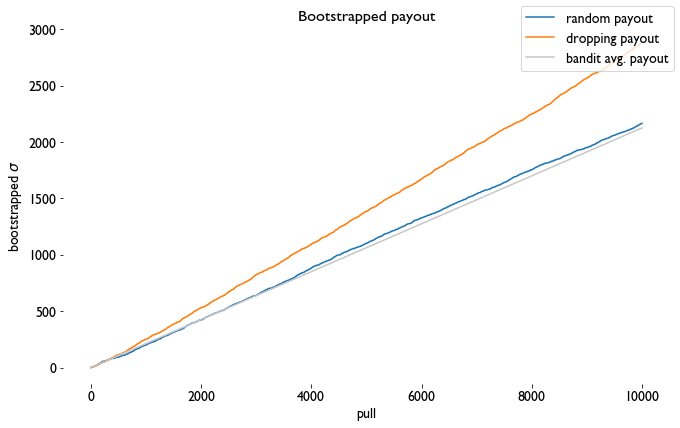

In [22]:
fig, ax = plt.subplots()

pulls = np.linspace(0, len(cum_payout_hist), len(cum_payout_hist))

ax.plot(cum_payout_hist, label='random payout')
ax.plot(cum_payout_hist_dropout, label='dropping payout')
ax.plot(np.average(payouts)*pulls, label='bandit avg. payout', c=tableau20['light_gray'])
    
ax.set_xlabel('pull')
ax.set_ylabel(r'bootstrapped $\sigma$')
ax.set_title('Bootstrapped payout')
fig.legend()
fig.tight_layout()
pass;